# 載入資料

In [ ]:
!gdown --id '1oT0qwtcfCACtQ6vzNWhAbAxrThvbS73B' --output 'cabbage.xlsx'
!gdown --id '1-2GdInJS8I5QOO3nJCKC9Bc6YG2j6o5m' --output 'weather.csv'
!gdown --id '1iKa9g_ZvDJE5EdYmlL-FA4AoVnKh____' --output 'mvrs.csv'

# 安裝套件

In [ ]:
%%capture
!pip install prophet
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from prophet import Prophet

In [ ]:
%%capture
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# 檢視資料

## 甘藍

,price,quantity
date,,
1996-01-01,8.690083,97132
1996-01-02,10.639402,78880
1996-01-03,9.939656,123859
1996-01-04,6.700000,27165
1996-01-05,8.052326,128812


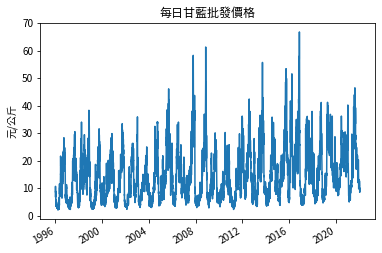

In [ ]:
df_c = pd.read_excel('cabbage.xlsx', index_col='date', parse_dates=True)
display(df_c.head())
df_c.price.plot()
plt.title('每日甘藍批發價格')
plt.ylabel('元/公斤')
plt.xlabel('')
plt.show()

In [ ]:
df_c['pq'] = df_c.price * df_c.quantity
df_c = df_c.resample('W-Fri', label='right').sum()
df_c.price = df_c.pq / df_c.quantity
df_c = df_c.drop(columns=['quantity', 'pq'])

,price
date,
1996-01-05,9.068108
1996-01-12,7.016792
1996-01-19,4.171009
1996-01-26,4.128958
1996-02-02,4.177750


,price
date,
2021-12-31,11.118384
2022-01-07,11.310858
2022-01-14,11.804070
2022-01-21,9.820779
2022-01-28,9.356194


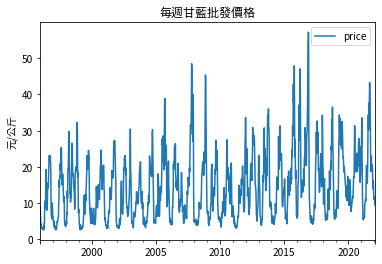

In [ ]:
display(df_c.head())
display(df_c.tail())
df_c.plot()
plt.title('每週甘藍批發價格')
plt.ylabel('元/公斤')
plt.xlabel('')
plt.show()

## 甘藍育苗

In [ ]:
df_m = pd.read_csv('mvrs.csv', index_col='date', parse_dates=True)
df_m.head()

,LA_num
date,
2011-01-05,6020.64
2011-01-15,5809.97
2011-01-25,6209.84
2011-02-05,4715.74
2011-02-15,4997.61


In [ ]:
df_m = df_m.resample('W-Fri', label='right').nearest()
display(df_m.head())
df_m.tail(10)

,LA_num
date,
2011-01-07,6020.64
2011-01-14,5809.97
2011-01-21,6209.84
2011-01-28,6209.84
2011-02-04,4715.74


,LA_num
date,
2021-10-29,7487.16
2021-11-05,7919.72
2021-11-12,8300.18
2021-11-19,8300.18
2021-11-26,4823.72
2021-12-03,4471.26
2021-12-10,3320.96
2021-12-17,3320.96
2021-12-24,3315.16


In [ ]:
df_m = df_m.shift(9).dropna()
display(df_m.head())
df_m.tail()

,LA_num
date,
2011-03-11,6020.64
2011-03-18,5809.97
2011-03-25,6209.84
2011-04-01,6209.84
2011-04-08,4715.74


,LA_num
date,
2021-12-03,6514.52
2021-12-10,6514.52
2021-12-17,6806.48
2021-12-24,7487.16
2021-12-31,7487.16


## 天氣

In [ ]:
cols = ['ObsTime', 'Temperature', 'Precp']
df_w = pd.read_csv('weather.csv', usecols=cols, index_col='ObsTime', parse_dates=True)
df_w.index.name = 'date' # ℃、mm
df_w.head()

,Temperature,Precp
date,,
2011-01-01,11.3,0.0
2011-01-02,14.1,0.0
2011-01-03,13.5,3.0
2011-01-04,13.1,0.1
2011-01-05,16.8,1.0


In [ ]:
df_w = df_w.resample('W-Fri', label='right').mean()
df_w['Temperature2'] = df_w.Temperature ** 2
df_w['Precp2'] = df_w.Precp ** 2
display(df_w.head())
df_w.tail()

,Temperature,Precp,Temperature2,Precp2
date,,,,
2011-01-07,13.428571,0.714286,180.326531,0.510204
2011-01-14,13.442857,7.614286,180.710408,57.977347
2011-01-21,14.014286,1.000000,196.400204,1.000000
2011-01-28,15.071429,0.385714,227.147959,0.148776
2011-02-04,14.071429,0.985714,198.005102,0.971633


,Temperature,Precp,Temperature2,Precp2
date,,,,
2021-12-03,19.185714,1.857143,368.091633,3.448980
2021-12-10,19.514286,2.785714,380.807347,7.760204
2021-12-17,20.514286,0.785714,420.835918,0.617347
2021-12-24,18.300000,3.428571,334.890000,11.755102
2021-12-31,15.700000,0.714286,246.490000,0.510204


## 合併

In [ ]:
df = pd.merge(df_c, df_m, how='outer', left_index=True, right_index=True)
df = pd.merge(df, df_w, how='outer', left_index=True, right_index=True)
# df = df.dropna()
df = df['2011-03-11':'2021']
dfall = df.copy()
print(df.shape)
display(df.head())
df.tail()

(565, 6)


,price,LA_num,Temperature,Precp,Temperature2,Precp2
date,,,,,,
2011-03-11,4.351267,6020.64,15.585714,8.000000,242.914490,64.000000
2011-03-18,3.421378,5809.97,17.071429,0.542857,291.433673,0.294694
2011-03-25,3.442451,6209.84,17.428571,0.128571,303.755102,0.016531
2011-04-01,3.818407,6209.84,16.357143,8.342857,267.556122,69.603265
2011-04-08,3.057363,4715.74,19.542857,0.428571,381.923265,0.183673


,price,LA_num,Temperature,Precp,Temperature2,Precp2
date,,,,,,
2021-12-03,14.733079,6514.52,19.185714,1.857143,368.091633,3.448980
2021-12-10,16.248890,6514.52,19.514286,2.785714,380.807347,7.760204
2021-12-17,13.145006,6806.48,20.514286,0.785714,420.835918,0.617347
2021-12-24,11.053453,7487.16,18.300000,3.428571,334.890000,11.755102
2021-12-31,11.118384,7487.16,15.700000,0.714286,246.490000,0.510204


In [ ]:
# df['price'] = np.log(df.price)
df['ln_price'] = np.log(df.price)

In [ ]:
print(df.isna().sum())

price           0
LA_num          0
Temperature     0
Precp           0
Temperature2    0
Precp2          0
ln_price        0
dtype: int64


# 切割資料集

In [ ]:
# Validation
val_df = df['2021-11':]

# Training
df = df[:'2021-10']

# 資料分析

## Visualization

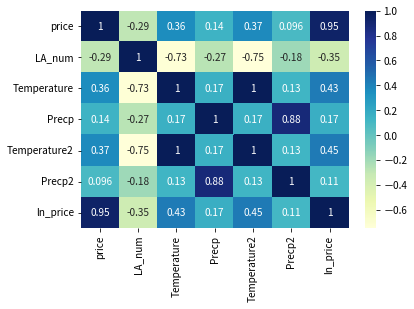

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.show()

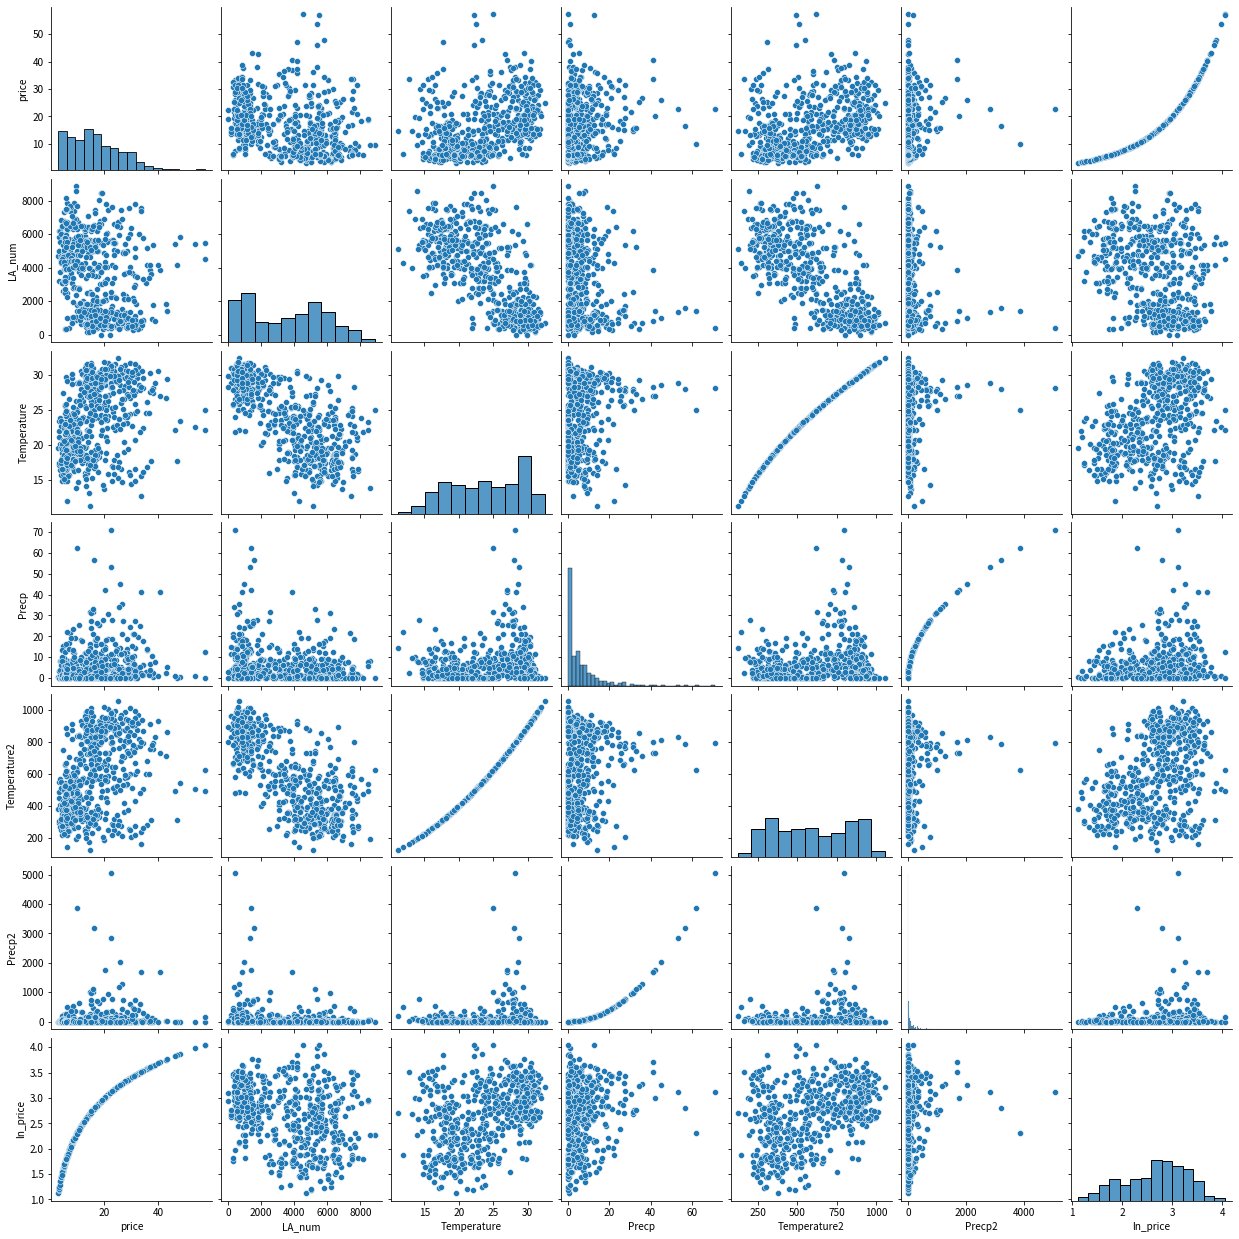

In [ ]:
sns.pairplot(df)
plt.show()

## Decompose

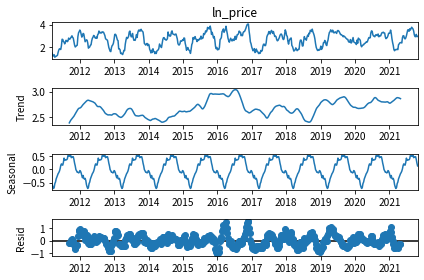

In [ ]:
decomp_results = seasonal_decompose(df.ln_price)
decomp_results.plot()
plt.show()

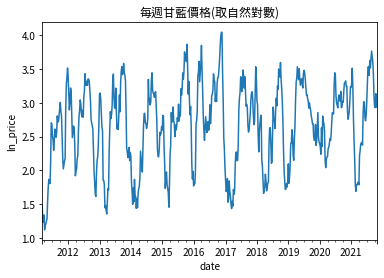

In [ ]:
df.ln_price.plot()
plt.title('每週甘藍價格(取自然對數)')
plt.ylabel('ln_price')
plt.show()

## ADF TEST

In [ ]:
# print(adfuller(df.price))
print(adfuller(df.ln_price))

(-6.8319884422339685, 1.8834696228451496e-09, 6, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, -210.15062334787376)


## ACF與PACF

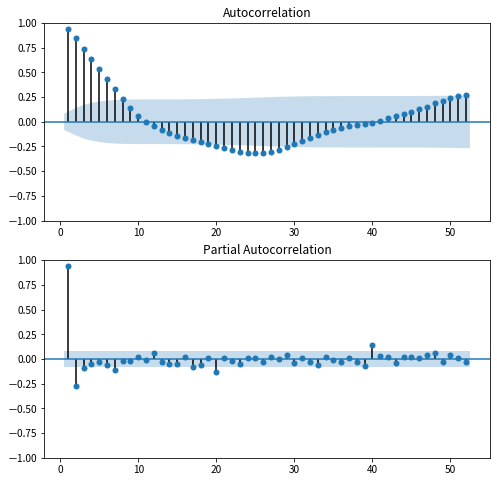

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# Make ACF plot
plot_acf(df.ln_price, lags=52, zero=False, ax=ax1)

# Make PACF plot
plot_pacf(df.ln_price, lags=52, zero=False, ax=ax2, method='ywm')
plt.show()

# 模型

## SARIMAX
$SARIMAX(p, d, q) \times (P, D, Q): Seasonal + ARIMA + Exogenous$

$AR(p): Y_t = \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \dots + \beta_pY_{t-p} + u_t$

$MR(q): Y_t = \theta_0 + \theta_1u_{t-1} + \theta_2u_{t-2} + \dots + \theta_qu_{t-q} + u_t$

$ARIMR(p, d, q): (1 - \sum_{i=1}^p \beta_i L^i)(1-L)^dY_t = (1 - \sum_{i=1}^q \theta_i L^i)u_t$, where $L$ stands for Lag operator.

In [ ]:
# result = pm.auto_arima(df.ln_price, X=df[['LA_num', 'Temperature', 'Precp']], seasonal=True, D=1, m=52)
# WEEK:  SARIMAX(3, 0, 0)x(2, 1, 0, 52) 
# MONTH: SARIMAX(2, 0, 0)x(2, 1, 0, 12)

In [ ]:
%%capture
model = SARIMAX(df.ln_price, exog=df[['LA_num', 'Temperature', 'Precp']],
                order=(3,0,0), seasonal_order=(2, 1, 0, 52))
result = model.fit()

In [ ]:
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           ln_price   No. Observations:                  556
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 52)   Log Likelihood                 -15.036
Date:                            Wed, 26 Jan 2022   AIC                             48.073
Time:                                    03:04:00   BIC                             86.076
Sample:                                03-11-2011   HQIC                            62.980
                                     - 10-29-2021                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
LA_num       -9.42e-06   2.07e-05     -0.456      0.648   -4.99e-05    3.11e-05
Temperature    -0.0342      0.00

### 樣本內(訓練資料)預測

In [ ]:
predicted = result.get_prediction(start=-10)
mean = predicted.predicted_mean
conf1 = predicted.conf_int(alpha=0.70)  # 30%
conf2 = predicted.conf_int(alpha=0.40)  # 60%

In [ ]:
mean = np.exp(predicted.predicted_mean)

conf1 = np.exp(conf1)
conf1.columns = ['lower price', 'upper price']

conf2 = np.exp(conf2)
conf2.columns = ['lower price', 'upper price']

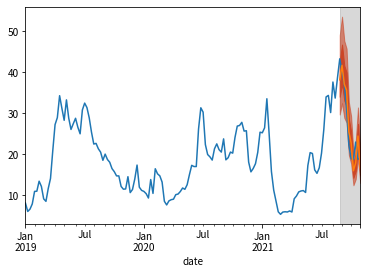

In [ ]:
fig, ax = plt.subplots()
df['2019':'2021'].price.plot(ax=ax, legend=False)
# df['2021':].price.plot(style=' ', ax=ax, legend=False)
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
plt.show()

### 樣本外(測試資料)預測

In [ ]:
forecast = result.get_forecast(steps=len(val_df), exog=val_df[['LA_num', 'Temperature', 'Precp']])
conf1 = forecast.conf_int(alpha=0.70)  # 30%
conf2 = forecast.conf_int(alpha=0.40)  # 60%

In [ ]:
mean = np.exp(forecast.predicted_mean).append(df.price[-1:]).sort_index()
lastp = df[['price', 'price']][-1:]
lastp.columns = ['lower price', 'upper price']
lastp.index.name = 'ds'

In [ ]:
conf1 = np.exp(conf1)
conf1.columns = ['lower price', 'upper price']
conf1 = conf1.append(lastp).sort_index()

conf2 = np.exp(conf2)
conf2.columns = ['lower price', 'upper price']
conf2 = conf2.append(lastp).sort_index()

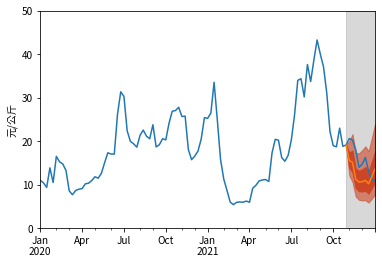

In [ ]:
fig, ax = plt.subplots()
df['2020':].price.plot(ax=ax, legend=False)
val_df.price.append(df.price[-1:]).sort_index().plot(color='C0')
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 50)
plt.show()

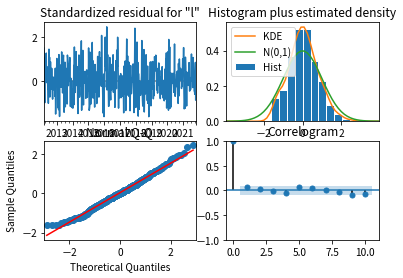

In [ ]:
result.plot_diagnostics() # pm.auto_arima(df, seasonal=True, m=7)
plt.show()

## fbporphet
$y(t) = g(t) + s(t) + h(t) + e(t)$

$g(t)$: trend models non-periodic changes.

$s(t)$: seasonality presents periodic changes.

$h(t)$: effects of holidays with irregular schedules.

$e(t)$: covers idiosyncratic changes not accommodated by the model.

### 設定資料

In [ ]:
dfp = df.reset_index()
dfp.columns = ['ds', 'price', 'LA_num', 'Temperature', 'Precp', 'Temperature2', 'Precp2', 'ln_price']
dfp['y'] = dfp.ln_price
dfp.tail()

,ds,price,LA_num,Temperature,Precp,Temperature2,Precp2,ln_price,y
551,2021-10-01,18.968285,0.00,28.328571,3.071429,802.507959,9.433673,2.942768,2.942768
552,2021-10-08,18.718567,3711.16,29.514286,0.000000,871.093061,0.000000,2.929516,2.929516
553,2021-10-15,23.008165,7630.39,28.285714,18.714286,800.081633,350.224490,3.135849,3.135849
554,2021-10-22,18.830983,8461.22,23.228571,7.500000,539.566531,56.250000,2.935504,2.935504
555,2021-10-29,19.119969,8461.22,22.200000,5.571429,492.840000,31.040816,2.950733,2.950733


In [ ]:
val_dfp = val_df.reset_index()
val_dfp.columns = ['ds', 'price', 'LA_num', 'Temperature', 'Precp', 'Temperature2', 'Precp2', 'ln_price']

### 樣本內(訓練資料)預測

In [ ]:
m = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('LA_num')
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'LA_num', 'Temperature', 'Precp']])

predict = m.make_future_dataframe(periods=0, freq='W-Fri', include_history=True)
predict['LA_num'] = df[['LA_num']].reset_index(drop=True)
predict['Temperature'] = df[['Temperature']].reset_index(drop=True)
predict['Precp'] = df[['Precp']].reset_index(drop=True)

fcst0 = m.predict(predict)
fcst0 = fcst0.set_index(fcst0.ds, drop=True)

### 不加入外生變數

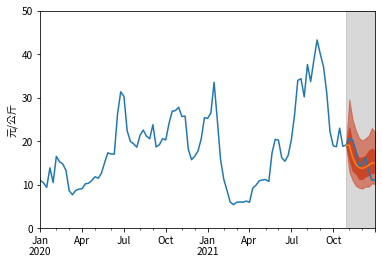

In [ ]:
dfp = df.reset_index()
dfp.columns = ['ds', 'price', 'LA_num', 'Temperature', 'Precp', 'Temperature2', 'Precp2', 'ln_price']
dfp['y'] = dfp.ln_price
dfp.tail()

val_dfp = val_df.reset_index()
val_dfp.columns = ['ds', 'price', 'LA_num', 'Temperature', 'Precp', 'Temperature2', 'Precp2', 'ln_price']

# 30% CI
m = Prophet(seasonality_mode='multiplicative', interval_width=0.30, daily_seasonality=False, weekly_seasonality=True)
m.fit(dfp[['ds', 'y']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W-Fri', include_history=False)

fcst1 = m.predict(future)
fcst1 = fcst1.set_index(fcst1.ds, drop=True)

# 60% CI
m = Prophet(seasonality_mode='multiplicative', interval_width=0.60, daily_seasonality=False, weekly_seasonality=True)
m.fit(dfp[['ds', 'y']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W-Fri', include_history=False)

fcst2 = m.predict(future)
fcst2 = fcst2.set_index(fcst2.ds, drop=True)

mean = np.exp(fcst1.yhat).append(df.price[-1:]).sort_index()

conf1 = np.exp(fcst1[['yhat_lower', 'yhat_upper']])
conf1.columns = ['lower price', 'upper price']
conf1 = conf1.append(lastp).sort_index()

conf2 = np.exp(fcst2[['yhat_lower', 'yhat_upper']])
conf2.columns = ['lower price', 'upper price']
conf2 = conf2.append(lastp).sort_index()

fig, ax = plt.subplots()
df['2020':].price.plot(ax=ax, legend=False)
val_df.price.append(df.price[-1:]).sort_index().plot(color='C0')
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 50)
plt.show()

### 樣本外(測試資料)預測

In [ ]:
# 30% CI
m = Prophet(seasonality_mode='multiplicative', interval_width=0.30, daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('LA_num')
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'LA_num', 'Temperature', 'Precp']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W-Fri', include_history=False)
future['LA_num'] = val_dfp[['LA_num']]
future['Temperature'] = val_dfp[['Temperature']]
future['Precp'] = val_dfp[['Precp']]

fcst1 = m.predict(future)
fcst1 = fcst1.set_index(fcst1.ds, drop=True)

# 60% CI
m = Prophet(seasonality_mode='multiplicative', interval_width=0.60, daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('LA_num')
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'LA_num', 'Temperature', 'Precp']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W-Fri', include_history=False)
future['LA_num'] = val_dfp[['LA_num']]
future['Temperature'] = val_dfp[['Temperature']]
future['Precp'] = val_dfp[['Precp']]

fcst2 = m.predict(future)
fcst2 = fcst2.set_index(fcst2.ds, drop=True)

In [ ]:
mean = np.exp(fcst1.yhat).append(df.price[-1:]).sort_index()

conf1 = np.exp(fcst1[['yhat_lower', 'yhat_upper']])
conf1.columns = ['lower price', 'upper price']
conf1 = conf1.append(lastp).sort_index()

conf2 = np.exp(fcst2[['yhat_lower', 'yhat_upper']])
conf2.columns = ['lower price', 'upper price']
conf2 = conf2.append(lastp).sort_index()

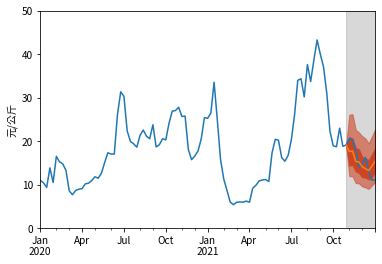

In [ ]:
fig, ax = plt.subplots()
df['2020':].price.plot(ax=ax, legend=False)
val_df.price.append(df.price[-1:]).sort_index().plot(color='C0')
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 50)
plt.show()

# 評估

## 準備評估資料

### 訓練資料(樣本內資料)

In [ ]:
dfins = pd.DataFrame({'y_real': df.price,
                      'y_sarimax': np.exp(result.get_prediction().predicted_mean),
                      'y_prophet': np.exp(fcst0.yhat)})
print(dfins.shape)
dfins.tail()

(513, 3)


,y_real,y_sarimax,y_prophet
2021-10-01,18.968023,22.066392,31.356226
2021-10-08,18.719329,18.347893,25.127960
2021-10-15,23.007601,19.174603,21.704655
2021-10-22,18.830657,19.447606,21.616324
2021-10-29,19.119908,16.977460,20.107229


### 測試資料(樣本外資料)

In [ ]:
dfoos = pd.DataFrame({'y_real': val_df.price,
                      'y_sarimax': np.exp(forecast.predicted_mean),
                      'y_prophet': np.exp(fcst1.yhat)})
print(dfoos.shape)
dfoos.head()

(9, 3)


,y_real,y_sarimax,y_prophet
2021-11-05,20.614654,15.597986,18.004759
2021-11-12,20.289238,15.070611,17.899063
2021-11-19,18.009465,11.061717,15.408682
2021-11-26,14.008558,10.488040,15.109867
2021-12-03,14.731450,10.515743,13.672850


## [評估標準](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

*   $\mbox{MSE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T(Y_t - \widehat{Y}_t)^2$

*   $\mbox{MAE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T|Y_t - \widehat{Y}_t|$

*   $\mbox{MAPE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T\frac{|Y_t - \widehat{Y}_t|}{max(u_t, |Y_t|)}$



## 樣本內評估

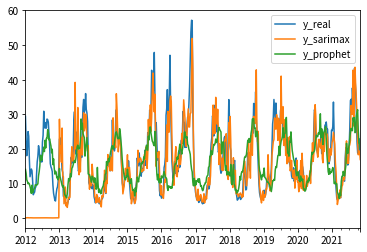

In [ ]:
dfins.plot()
plt.show()

In [ ]:
mse = [mean_squared_error(dfins.y_real, dfins.y_sarimax),
       mean_squared_error(dfins.y_real, dfins.y_prophet)]
mae = [mean_absolute_error(dfins.y_real, dfins.y_sarimax),
       mean_absolute_error(dfins.y_real, dfins.y_prophet)]
mape = [mean_absolute_percentage_error(dfins.y_real, dfins.y_sarimax),
        mean_absolute_percentage_error(dfins.y_real, dfins.y_prophet)]
dfv_ins = pd.DataFrame({'MSE': mse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_ins

,MSE,MAE,MAPE
SARIMAX,53.254709,4.651203,0.275267
prophet,63.297210,5.567808,0.358236


## 樣本外評估

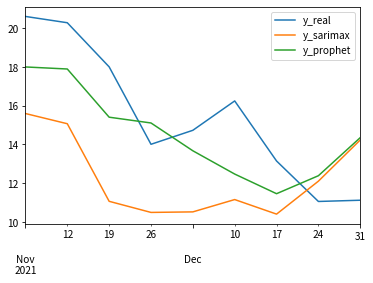

In [ ]:
dfoos.plot()
plt.show()

In [ ]:
mse = [mean_squared_error(dfoos.y_real, dfoos.y_sarimax),
       mean_squared_error(dfoos.y_real, dfoos.y_prophet)]
rmse = [np.sqrt(mean_squared_error(dfoos.y_real, dfoos.y_sarimax)),
        np.sqrt(mean_squared_error(dfoos.y_real, dfoos.y_prophet))]
mae = [mean_absolute_error(dfoos.y_real, dfoos.y_sarimax),
       mean_absolute_error(dfoos.y_real, dfoos.y_prophet)]
mape = [mean_absolute_percentage_error(dfoos.y_real, dfoos.y_sarimax),
      mean_absolute_percentage_error(dfoos.y_real, dfoos.y_prophet)]
dfv_oos = pd.DataFrame({'MSE': mse,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_oos

,MSE,RMSE,MAE,MAPE
SARIMAX,19.460388,4.411393,4.102592,0.257917
prophet,5.665555,2.380243,2.199403,0.145746


In [ ]:
# log(Price)
mse = [mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
       mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
rmse = [np.sqrt(mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax))),
        np.sqrt(mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet)))]
mae = [mean_absolute_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
       mean_absolute_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
mape = [mean_absolute_percentage_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
      mean_absolute_percentage_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
dfv_oos = pd.DataFrame({'MSE': mse,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_oos

,MSE,RMSE,MAE,MAPE
SARIMAX,0.096318,0.310351,0.293145,0.106740
prophet,0.026308,0.162198,0.148694,0.055378


$\mbox{Lewis(1982)}$

$\mbox{MAPE} < 10\%： \mbox{Highly accurate forcasting}$

$ 10\%< \mbox{MAPE} < 20\%： \mbox{Good forecasting}$

$ 20\%< \mbox{MAPE} < 50\%： \mbox{Reasonable forecasting}$

$ \mbox{MAPE} > 20\%： \mbox{Week and inaccurate forecasting}$

Those Lewis numbers are fairly arbitrary, 
you can't just say that a 20% error is good forecasting because some guy wrote it in a book 40 years ago.The acceptable margin or error completely depends on the problem domain. In some situations a model that gives a 20% error will be great, in others it will be unusable. I know its tempting to rely on general rules like the ones you posted because they feel 'objective', but they are ultimately arbitrary and can't override common sense and domain expertise.

# 繪製扇形圖

In [ ]:
# 30% CI
m = Prophet(seasonality_mode='multiplicative', interval_width=0.30, daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('LA_num')
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'LA_num', 'Temperature', 'Precp']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W-Fri', include_history=False)
future['LA_num'] = val_dfp[['LA_num']]
future['Temperature'] = val_dfp[['Temperature']]
future['Precp'] = val_dfp[['Precp']]

fcst1 = m.predict(future)
fcst1 = fcst1.set_index(fcst1.ds, drop=True)

# 60% CI
m = Prophet(seasonality_mode='multiplicative', interval_width=0.60, daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('LA_num')
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'LA_num', 'Temperature', 'Precp']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W-Fri', include_history=False)
future['LA_num'] = val_dfp[['LA_num']]
future['Temperature'] = val_dfp[['Temperature']]
future['Precp'] = val_dfp[['Precp']]

fcst2 = m.predict(future)
fcst2 = fcst2.set_index(fcst2.ds, drop=True)

# 信賴區間
mean = np.exp(fcst1.yhat).append(df.price[-1:]).sort_index()

conf1 = np.exp(fcst1[['yhat_lower', 'yhat_upper']])
conf1.columns = ['lower price', 'upper price']
conf1 = conf1.append(lastp).sort_index()

conf2 = np.exp(fcst2[['yhat_lower', 'yhat_upper']])
conf2.columns = ['lower price', 'upper price']
conf2 = conf2.append(lastp).sort_index()

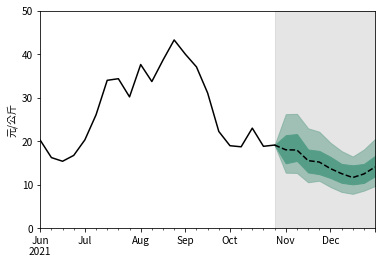

In [ ]:
fig, ax = plt.subplots()
df['2021-06':'2021'].price.plot(ax=ax, legend=False, color='black')
# val_df.price.append(df.price[-1:]).sort_index().plot(color='black', linestyle='--')
mean.plot(color='black', linestyle='--')
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.2)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='#199370', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='#6eb29b', alpha=0.6, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 50)
plt.show()

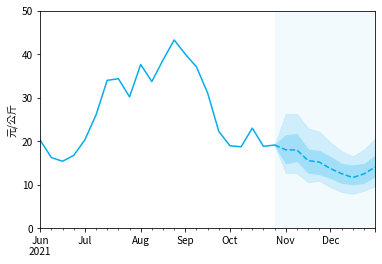

In [ ]:
fig, ax = plt.subplots()
df['2021-06':'2021'].price.plot(ax=ax, legend=False, color='#00adee')
# val_df.price.append(df.price[-1:]).sort_index().plot(color='#00adee', linestyle='--')
mean.plot(color='#00adee', linestyle='--')
plt.axvspan(mean.index.min(), mean.index.max(), color='#e2f4fd', alpha=0.4)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='#00adee', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='#aae1fa', alpha=0.7, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 50)
plt.show()